## 7.2 Experiment Region Proposal

⚠️⚠️⚠️ *Please open this notebook in Google Colab* by click below link ⚠️⚠️⚠️<br><br>
<a href="https://colab.research.google.com/github/Muhammad-Yunus/Belajar-OpenCV-ObjectDetection/blob/main/Pertemuan%207/7.2%20experiment_region_proposal.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><br><br><br>
- Click `Connect` button in top right Google Colab notebook,<br>
<img src="resource/cl-connect-gpu.png" width="250px">
- If connecting process completed, it will turn to something look like this<br>
<img src="resource/cl-connect-gpu-success.png" width="250px">

_________
<br><br><br><br>
#### 7.2.1 <font color="orange">Selective Search</font>
- Simple implementation Selective Search using OpenCV to perform segmentation based on color similarity
- Then producing proposed bounding box as a result countour of segmented image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

- Load the image

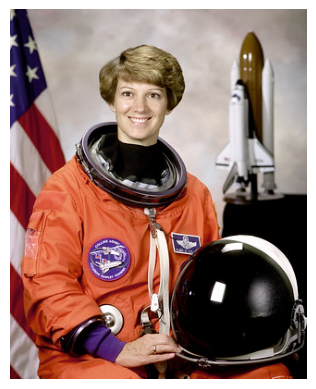

In [3]:
image = cv2.imread("astronaut.jpg")

# show image using matplot lib
def imshow(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

imshow(image)

- Define function for color quantization using <font color="orange">K-means clustering</font>,
    - Choose Number of <font color="orange">Clusters</font> ($k$),
        - For example, if you have a bunch of points and want to split them into 3 groups, you set $k=3$.
    - Initialize <font color="orange">Centroids</font>,
        - Randomly place $k$ points (called <font color="orange">centroids</font>) in the space where your data points lie. 
    - Update Centroids,
        - For each cluster, calculate the <font color="orange">average</font> of all points assigned to that cluster. 
        - This <font color="orange">new average</font> becomes the updated <font color="orange">centroid</font> for the cluster.
    - <font color="orange">Repeat</font> Until Stable,
        - Steps 3 and 4 are repeated until the centroids <font color="orange">no longer change</font> much (or at all) between iterations.
        - This means each data point has found its "best" cluster.<br><br>
        <img src="resource/K-Means.gif" width="900px"><br>


- Implement K-Means Clustering using OpenCV `cv2.kmeans()`,
    ```
    retval, bestLabels, centers = cv2.kmeans(data, K, bestLabels, criteria, attempts, flags)
    ```
    - where :
        - `K` Number of clusters to split the set by.
        - `bestLabels` Input/output integer array that stores the cluster indices for every sample.
        - `criteria` The algorithm termination criteria, can be the maximum number of iterations and/or the desired accuracy. 
        - `attempts` to specify the number of times the algorithm is executed using different initial labellings. 
        - `flags` to set random initial centers in each attempt. can take values of,
            - cv2.KMEANS_RANDOM_CENTERS     = 0,
            - cv2.KMEANS_PP_CENTERS         = 2,
            - cv2.KMEANS_USE_INITIAL_LABELS = 1,


In [6]:
def color_quantization(image, k=5):
    # Convert to Lab color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Reshape the image data to a 2D array of pixels
    pixel_values = image_lab.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply KMeans clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 15, cv2.KMEANS_RANDOM_CENTERS)
    
    centers = np.uint8(centers)
    quantized_image = centers[labels.flatten()]

    # Reshape back to the original image dimensions
    quantized_image = quantized_image.reshape(image.shape)
    return cv2.cvtColor(quantized_image, cv2.COLOR_Lab2BGR)

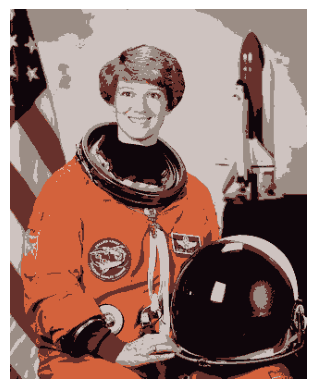

In [34]:
# generate segmented image using k=4
segmented_image = color_quantization(image, k=5)

# show segmented image
imshow(segmented_image)

- Define function to extract Bounding Box from segmented image
    - Convert `segmented_image` to binary image (black & white) using Otsu Thresholding (`cv2.THRESH_OTSU`),
    - Find contour on binary image using `cv2.findContours()`,
    - Find Bouding Box on detecting contour using `cv2.boundingRect()`
    - Filter box size $w*h$ >= $min size$

In [35]:
def get_bounding_boxes(segmented_image, min_size=200):
    # Convert to grayscale and apply binary thresholding
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create bounding boxes for contours larger than min_size
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h >= min_size:
            boxes.append((x, y, w, h))
    return boxes

In [38]:
boxes = get_bounding_boxes(segmented_image, min_size=500)

print(boxes)

[(243, 386, 57, 14), (212, 370, 95, 14), (239, 346, 72, 33), (0, 329, 41, 71), (133, 320, 30, 37), (90, 283, 60, 41), (67, 276, 16, 32), (96, 256, 37, 40), (83, 246, 42, 34), (129, 245, 17, 46), (69, 121, 124, 113), (95, 67, 24, 38), (142, 52, 48, 60), (244, 24, 32, 126), (0, 0, 321, 400)]


- Draw bounding box on original image using `cv2.rectangle`

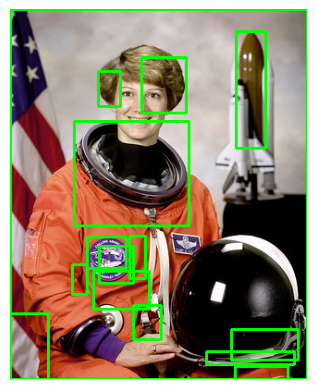

In [39]:
# define maximun number of box to draw
MAX_BOX = 100

# draw box in original image
image_with_boxes = image.copy()
for (x, y, w, h) in boxes[:MAX_BOX]:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# show image with bounding box
imshow(image_with_boxes)

_______
<br><br><br><br>
### 7.2.2 <font color="orange">RPN</font> (Region Proposal Network)
- <font color="orange">Anchor Generation</font> : Define anchor boxes of multiple scales and aspect ratios for each position in a feature map.
- <font color="orange">RPN Network Layers</font> : The RPN typically has a <font color="orange">3x3 convolutional layer</font> to scan over the feature map and two output branches:
    - A classification branch (object vs. background) using <font color="orange">1x1 convolutional layer</font>.
    - A regression branch (bounding box refinements) using <font color="orange">1x1 convolutional layer</font>.
- <font color="orange">Loss Functions</font> : Compute classification and regression loss to train the network.<br>
        <img src="resource/RPN.png" width="700px"><br>

- RPN Implementation in PyTorch

In [ ]:
import torch
import torch.nn as nn
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class RPN(nn.Module):
    def __init__(self, in_channels=512, num_anchors=9):
        super(RPN, self).__init__()
        
        # 3x3 Conv layer for sliding window over the feature map
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        
        # Classification layer: predict if each anchor is an object or not
        # Output 2 scores per anchor: object or background
        self.cls_score = nn.Conv2d(512, num_anchors * 2, kernel_size=1)
        
        # Regression layer: predict 4 adjustments for each anchor's bbox (dx, dy, dw, dh)
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for layer in [self.conv, self.cls_score, self.bbox_pred]:
            nn.init.normal_(layer.weight, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        # Shared convolutional layer
        x = F.relu(self.conv(x))
        
        # Classification score for each anchor (object vs. background)
        cls_score = self.cls_score(x)
        
        # Bounding box refinement for each anchor
        bbox_pred = self.bbox_pred(x)
        
        # Reshape for output
        # cls_score: [batch, num_anchors * 2, H, W] -> [batch, H * W * num_anchors, 2]
        cls_score = cls_score.permute(0, 2, 3, 1).contiguous()
        cls_score = cls_score.view(cls_score.shape[0], -1, 2)
        
        # bbox_pred: [batch, num_anchors * 4, H, W] -> [batch, H * W * num_anchors, 4]
        bbox_pred = bbox_pred.permute(0, 2, 3, 1).contiguous()
        bbox_pred = bbox_pred.view(bbox_pred.shape[0], -1, 4)
        
        return cls_score, bbox_pred

>⚠️⚠️⚠️
>- On above implementation, the sliding window concept and anchor-based feature extraction aren't explicitly visible.
>- However, the 3x3 convolution inherently works as a sliding window,

- Load pretrained ResNet-34 from torch.hub

In [ ]:
# Load pretrained ResNet-34 from torch hub
backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

# Remove the fully connected layers, keep convolutional layers only
backbone = nn.Sequential(*list(backbone.children())[:-2])  # This keeps layers up to the last Conv layer
backbone.eval()  # Set backbone to evaluation mode

- Load Image Sample

In [ ]:
# Load an example image and preprocess it
image_path = 'astronaut.jpg'  # Replace with your image path
input_image = cv2.imread(image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (224, 224))  # Resize to a suitable input size for ResNet

# Convert image to tensor and normalize as required by ResNet
input_tensor = torch.tensor(input_image).float().permute(2, 0, 1).unsqueeze(0)
input_tensor = input_tensor / 255.0
input_tensor = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)(input_tensor)

- Forward pass image tensor to CNN Backbone (Resnet-34)

In [ ]:
# Generate feature map using ResNet-34
with torch.no_grad():  # No need to compute gradients here
    feature_map = backbone(input_tensor)

- Initialize RPN

In [ ]:
# Initialize RPN with input channels matching the ResNet output (512 channels in ResNet-34)
rpn = RPN(in_channels=512, num_anchors=9)

- Forward pass output feature map from backbone network to RPN

In [ ]:
# Run the feature map through RPN to get region proposals
cls_scores, bbox_preds = rpn(feature_map)

print(f"Feature map shape: {feature_map.shape}")
print(f"Class scores shape: {cls_scores.shape}")
print(f"Bbox predictions shape: {bbox_preds.shape}")

- Decoding the Predicted Boxes

_____
<br>
<br>
<br>
<br>

## Source
- https://www.linkedin.com/pulse/basic-building-blocks-k-means-clustering-algorithms-hemant-thapa-jnide/